# Model Development

In [95]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras import Model
from keras.optimizers import Adam

from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions

from model import load_train_val_generator

CSV_PATH = '../data/pokemon.csv'
IMAGES_FOLDER = '../data/images/images'
IMG_WIDTH, IMG_HEIGHT = 128,128
NB_CLASSES = 18
BATCH_SIZE = 32
EPOCHS = 300

## Data Loading

In [70]:
train_generator, validation_generator, test_generator = load_train_val_generator()
classes = list(validation_generator.class_indices)

Found 647 validated image filenames belonging to 18 classes.
Found 81 validated image filenames belonging to 18 classes.
Found 81 validated image filenames belonging to 18 classes.


## Model implementation

In [30]:
# MobileNetV2 pre-trained on ImageNet, without fully-connected layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# GlobalAveragePooling2D layer for dimensional reduction
x = GlobalAveragePooling2D()(base_model.output)

# fully-connected layer for 18 classes multi-label classification
predictions = Dense(NB_CLASSES, activation='sigmoid')(x)

# no training for the layers
for layer in base_model.layers:
    layer.trainable = False
    
model = Model(inputs=base_model.input, outputs=predictions)

# compilation with most appropriate loss function for multi-label classification
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [31]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=5, verbose=0
)

# training 
model_info = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/300


/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


21/21 [==============================] - 7s 242ms/step - loss: 0.3882 - accuracy: 0.0773 - val_loss: 0.3457 - val_accuracy: 0.0864
Epoch 2/300
21/21 [==============================] - 4s 204ms/step - loss: 0.2966 - accuracy: 0.1453 - val_loss: 0.3008 - val_accuracy: 0.0864
Epoch 3/300
21/21 [==============================] - 4s 207ms/step - loss: 0.2607 - accuracy: 0.1870 - val_loss: 0.2872 - val_accuracy: 0.1605
Epoch 4/300
21/21 [==============================] - 5s 224ms/step - loss: 0.2379 - accuracy: 0.2983 - val_loss: 0.2831 - val_accuracy: 0.1358
Epoch 5/300
21/21 [==============================] - 5s 220ms/step - loss: 0.2205 - accuracy: 0.3447 - val_loss: 0.2797 - val_accuracy: 0.1728
Epoch 6/300
21/21 [==============================] - 4s 216ms/step - loss: 0.2049 - accuracy: 0.4111 - val_loss: 0.2777 - val_accuracy: 0.1481
Epoch 7/300
21/21 [==============================] - 5s 230ms/step - loss: 0.1944 - accuracy: 0.4482 - val_loss: 0.2763 - val_accuracy: 0.1605
Epoch 8/300

## Results

3/3 - 1s - loss: 0.2698 - accuracy: 0.2222 - 551ms/epoch - 184ms/step


Loss on test set : 0.27 ; Categorical accuracy on test set : 0.222


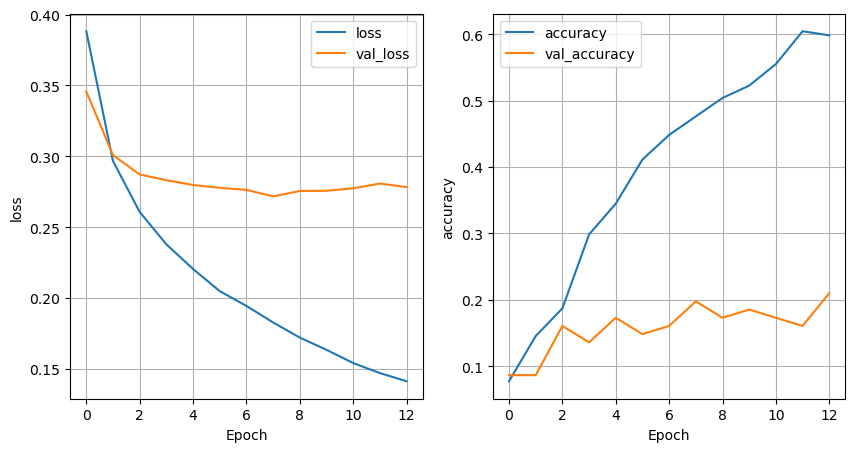

In [96]:
keys = list(model_info.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)

for idx, ax in enumerate(axes): 

    axes[idx].plot(model_info.history[keys[idx]], label=keys[idx])
    axes[idx].plot(model_info.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

test_loss, test_acc = model.evaluate(test_generator, verbose=2); 
print("\n\nLoss on test set : {:.3} ; Categorical accuracy on test set : {:.3f}".format(test_loss, test_acc))

In [84]:
df = pd.read_csv(CSV_PATH)
images_path = os.listdir(IMAGES_FOLDER)

def find_image_path_with_name(_name):
    if os.path.exists(os.path.join(IMAGES_FOLDER, _name+'.png')):
        return _name + '.png'
    else:
        return _name + '.jpg'
    

df['path'] = df.apply(lambda row: find_image_path_with_name(row['Name']), axis=1)

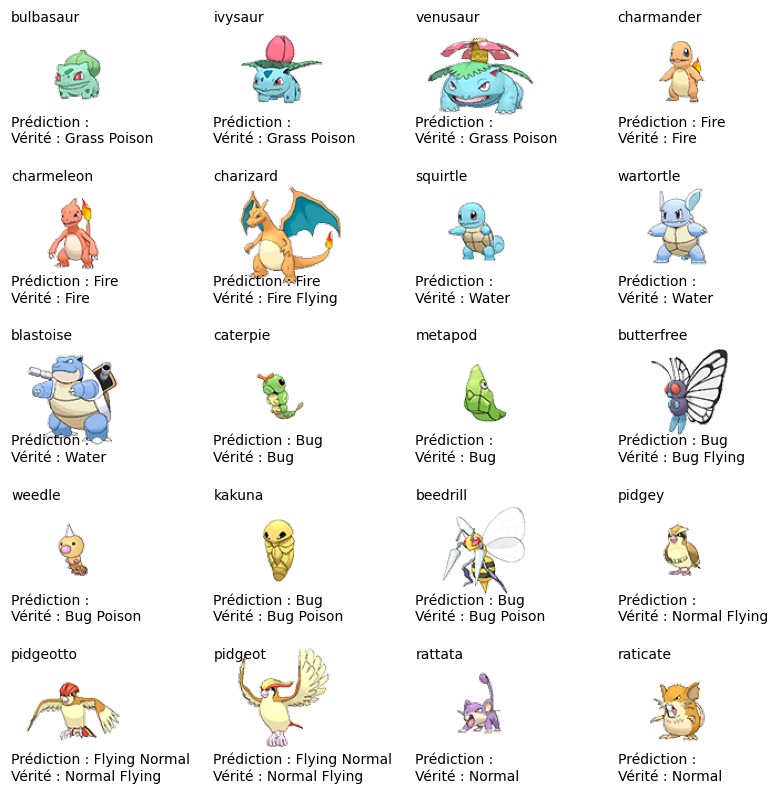

In [94]:
threshold = 0.5

fig, axes = plt.subplots(5, 4, figsize=(10, 10))
for i, ax in enumerate(axes.reshape(-1)):
    img_path = os.path.join(IMAGES_FOLDER, df['path'][i])
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array, verbose=0)
    str_predictions = '' 
    for j, prob in enumerate(predictions[0]):
        if prob > threshold:
            str_predictions += classes[j] + " "
    
    ax.imshow(Image.open(str(img_path)))
    ax.text(0.5, 10, df['Name'][i])
    ax.text(0.5, 105, f"Prédiction : {str_predictions}")
    ax.text(0.5, 120, "Vérité : " + df['Type1'][i] + " " + str(df['Type2'][i]).replace('nan', ''))
    ax.axis(False)

In [97]:
model.save("first_model.h5")

/home/omar/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
